# Numbers Summation(using RNN)

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on GitHub
> - ▶️ Demo: [try this model in action](https://trekhleb.github.io/machine-learning-experiments)

## Experiment overview

In this experiment we will use character-based [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNN) to 

![numbers_summation_rnn.png](../../demos/src/images/numbers_summation_rnn.png)

Inspired by [Learn to Add Numbers with an Encoder-Decoder LSTM Recurrent Neural Network](https://machinelearningmastery.com/learn-add-numbers-seq2seq-recurrent-neural-networks/) article.

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import random
import math

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [3]:
dataset_size = 5000
sequence_length = 2
max_num = 100

In [4]:
def generate_sums(dataset_size, sequence_length, max_num):
    # Initial dataset states.
    x, y = [], []
    
    # Generating sums.
    for i in range(dataset_size):
        sequence = [random.randint(1, max_num) for _ in range(sequence_length)]
        x.append(sequence)
        y.append(sum(sequence))
    
    return x, y

In [5]:
x_train, y_train = generate_sums(
    dataset_size=dataset_size,
    sequence_length=sequence_length,
    max_num=max_num
)

print('x_train:\n', x_train[:3])
print()
print('y_train:\n', y_train[:3])

x_train:
 [[41, 85], [50, 94], [86, 7]]

y_train:
 [126, 144, 93]


In [6]:
def dataset_to_strings(x, y, max_num):
    # Initial dataset states.
    x_str, y_str = [], []
    
    sequnce_length = len(x[0])
    
    # Calculate the maximum length of equation (x) string (i.e. of "11+99")
    num_of_pluses = sequnce_length - 1
    num_of_chars_per_digit = math.ceil(math.log10(max_num + 1))
    max_x_length = sequnce_length * num_of_chars_per_digit + num_of_pluses
    
    # Calculate the maximum length of label (y) string (i.e. of "167")
    max_y_length = math.ceil(math.log10(sequnce_length * (max_num + 1)))
    
    # Add a space " " padding to equation strings to make them of the same length.
    for example in x:
        str_example = '+'.join([str(digit) for digit in example])
        str_example += ''.join([' ' for padding in range(max_x_length - len(str_example))])
        x_str.append(str_example)
    
    # Add a space " " padding to labels strings to make them of the same length.
    for label in y:
        str_example = str(label)
        str_example += ''.join([' ' for padding in range(max_y_length - len(str_example))])
        y_str.append(str_example)
    
    return x_str, y_str

In [7]:
x_train_str, y_train_str = dataset_to_strings(x_train, y_train, max_num)

print('x_train_str:\n', np.array(x_train_str[:3]))
print()
print('y_train_str:\n', np.array(y_train_str[:3]))

x_train_str:
 ['41+85  ' '50+94  ' '86+7   ']

y_train_str:
 ['126' '144' '93 ']


In [8]:
vocabulary = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ' ']

In [9]:
char_to_index = {char: index for index, char in enumerate(vocabulary)}

print(char_to_index)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, ' ': 11}


In [10]:
def dataset_to_indices(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    char_to_index = {char: index for index, char in enumerate(vocabulary)}
    
    for example in x:
        example_encoded = [char_to_index[char] for char in example]
        x_encoded.append(example_encoded)
        
    for label in y:
        label_encoded = [char_to_index[char] for char in label]
        y_encoded.append(label_encoded)
        
    return x_encoded, y_encoded

In [11]:
x_train_encoded, y_train_encoded = dataset_to_indices(
    x_train_str,
    y_train_str,
    vocabulary
)

print('x_train_encoded:\n', np.array(x_train_encoded[:3]))
print()
print('y_train_encoded:\n', np.array(y_train_encoded[:3]))

x_train_encoded:
 [[ 4  1 10  8  5 11 11]
 [ 5  0 10  9  4 11 11]
 [ 8  6 10  7 11 11 11]]

y_train_encoded:
 [[ 1  2  6]
 [ 1  4  4]
 [ 9  3 11]]


In [12]:
def dataset_to_one_hot(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    for example in x:
        pattern = []
        for index in example:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        x_encoded.append(pattern)
            
    for label in y:
        pattern = []
        for index in label:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        y_encoded.append(pattern)
        
    return x_encoded, y_encoded

In [13]:
x_train_one_hot, y_train_one_hot = dataset_to_one_hot(
    x_train_encoded,
    y_train_encoded,
    vocabulary
)

print('x_train_one_hot:\n', np.array(x_train_one_hot[:1]))
print()
print('y_train_one_hot:\n', np.array(y_train_one_hot[:1]))

x_train_one_hot:
 [[[0 0 0 0 1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_train_one_hot:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]]]


In [14]:
def generate_dataset(dataset_size, sequence_length, max_num, vocabulary):
    # Generate integet sum sequences.
    x, y = generate_sums(dataset_size, sequence_length, max_num)
    # Convert integer sum sequences into strings.
    x, y = dataset_to_strings(x, y, max_num)
    # Encode each character to a char indices.
    x, y = dataset_to_indices(x, y, vocabulary)
    # Encode each index into one-hot vector.
    x, y = dataset_to_one_hot(x, y, vocabulary)
    # Return the data.
    return np.array(x), np.array(y)

In [15]:
x, y = generate_dataset(
    dataset_size,
    sequence_length,
    max_num,
    vocabulary
)

print('x:\n', x[:1])
print()
print('y:\n', y[:1])

x:
 [[[0 0 0 0 0 0 0 1 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]]]


In [16]:
print('x.shape: ', x.shape) # (input_sequences_num, input_sequence_length, supported_symbols_num)
print('y.shape: ', y.shape) # (output_sequences_num, output_sequence_length, supported_symbols_num)

x.shape:  (5000, 7, 12)
y.shape:  (5000, 3, 12)


In [17]:
input_sequence_length = x.shape[1]
output_sequence_length = y.shape[1]
supported_symbols_num = x.shape[2]
vocabulary_size = len(vocabulary)

print('input_sequence_length: ', input_sequence_length)
print('output_sequence_length: ', output_sequence_length)
print('supported_symbols_num: ', supported_symbols_num)
print('vocabulary_size: ', vocabulary_size)

input_sequence_length:  7
output_sequence_length:  3
supported_symbols_num:  12
vocabulary_size:  12


In [18]:
def decode(sequence, vocabulary):
    index_to_char = {index: char for index, char in enumerate(vocabulary)}
    strings = []
    for char_vector in sequence:
        char = index_to_char[np.argmax(char_vector)]
        strings.append(char)
    return ''.join(strings)

In [19]:
decode(y[0], vocabulary)

'155'

In [20]:
epochs_num = 150
batch_size = 128

In [21]:
model = tf.keras.models.Sequential()

# Encoder.

model.add(tf.keras.layers.LSTM(
    units=128,
    input_shape=(input_sequence_length, vocabulary_size),
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

# Decoder.

model.add(tf.keras.layers.RepeatVector(
    n=output_sequence_length,
))

model.add(tf.keras.layers.LSTM(
    units=128,
    return_sequences=True,
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

model.add(tf.keras.layers.TimeDistributed(
    layer=tf.keras.layers.Dense(
        units=vocabulary_size,
    )
))

model.add(tf.keras.layers.Activation(
    activation='softmax'
))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 12)             1548      
_________________________________________________________________
activation (Activation)      (None, 3, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


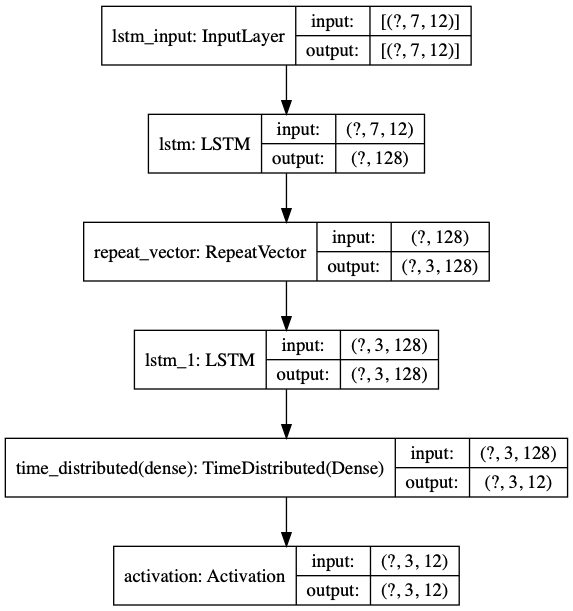

In [23]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [24]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    x=x,
    y=y,
    epochs=epochs_num,
    batch_size=batch_size,
    validation_split=0.1
)

Train on 4500 samples, validate on 500 samples
Epoch 1/150
4500/4500 [==============================] - 7s 1ms/sample - loss: 2.3134 - accuracy: 0.2361 - val_loss: 2.1245 - val_accuracy: 0.3820
Epoch 2/150
4500/4500 [==============================] - 1s 313us/sample - loss: 1.9389 - accuracy: 0.3807 - val_loss: 1.8375 - val_accuracy: 0.3820
Epoch 3/150
4500/4500 [==============================] - 2s 354us/sample - loss: 1.8059 - accuracy: 0.3872 - val_loss: 1.7885 - val_accuracy: 0.3807
Epoch 4/150
4500/4500 [==============================] - 1s 320us/sample - loss: 1.7518 - accuracy: 0.3876 - val_loss: 1.7376 - val_accuracy: 0.3900
Epoch 5/150
4500/4500 [==============================] - 1s 332us/sample - loss: 1.7255 - accuracy: 0.3892 - val_loss: 1.7201 - val_accuracy: 0.3933
Epoch 6/150
4500/4500 [==============================] - 1s 309us/sample - loss: 1.6954 - accuracy: 0.3973 - val_loss: 1.6975 - val_accuracy: 0.4100
Epoch 7/150
4500/4500 [==============================] - 1s 2

4500/4500 [==============================] - 1s 320us/sample - loss: 0.2179 - accuracy: 0.9321 - val_loss: 0.1212 - val_accuracy: 0.9733
Epoch 110/150
4500/4500 [==============================] - 1s 298us/sample - loss: 0.0918 - accuracy: 0.9861 - val_loss: 0.0957 - val_accuracy: 0.9813
Epoch 111/150
4500/4500 [==============================] - 1s 276us/sample - loss: 0.0753 - accuracy: 0.9923 - val_loss: 0.0892 - val_accuracy: 0.9793
Epoch 112/150
4500/4500 [==============================] - 1s 258us/sample - loss: 0.0717 - accuracy: 0.9924 - val_loss: 0.0875 - val_accuracy: 0.9853
Epoch 113/150
4500/4500 [==============================] - 1s 256us/sample - loss: 0.0687 - accuracy: 0.9934 - val_loss: 0.0834 - val_accuracy: 0.9847
Epoch 114/150
4500/4500 [==============================] - 1s 262us/sample - loss: 0.0664 - accuracy: 0.9931 - val_loss: 0.0793 - val_accuracy: 0.9887
Epoch 115/150
4500/4500 [==============================] - 1s 245us/sample - loss: 0.0641 - accuracy: 0.9935

In [26]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

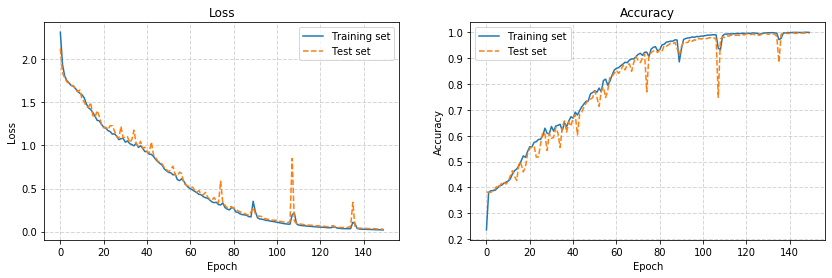

In [27]:
render_training_history(history)

In [28]:
x_test, y_test = generate_dataset(dataset_size, sequence_length, max_num, vocabulary)

print('x_test:\n', x_test[:1])
print()
print('y_test:\n', y_test[:1])

x_test:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_test:
 [[[0 0 0 0 0 0 0 0 0 1 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]


In [29]:
predictions = model.predict(x_test)

print('predictions.shape: ', predictions.shape)
print()
print('predictions[0]:\n', predictions[0])
print()
print('predictions[1]:\n', predictions[1])

predictions.shape:  (5000, 3, 12)

predictions[0]:
 [[2.0272466e-06 7.2857767e-02 1.2695995e-07 1.1758078e-09 4.2764250e-10
  2.6303539e-08 2.8986920e-08 5.4364377e-06 6.8420791e-03 9.2029250e-01
  4.9656177e-09 1.2583241e-09]
 [3.2795721e-03 9.6711224e-01 2.9406181e-02 1.9649228e-04 8.1709106e-07
  5.4945912e-07 1.2811645e-07 2.7084734e-10 5.9132327e-10 3.9648303e-06
  9.7864972e-10 6.0267048e-08]
 [5.6906288e-06 1.4028348e-04 3.3346203e-04 1.3765302e-05 5.6278748e-07
  9.4114391e-08 7.3364856e-09 4.7401553e-12 2.6028010e-12 6.2642300e-08
  7.6568725e-09 9.9950600e-01]]

predictions[1]:
 [[7.1216213e-08 1.1571822e-03 5.9638667e-09 1.6718470e-10 2.2537704e-10
  4.2034760e-08 8.2438632e-08 1.0809344e-05 6.6148862e-03 9.9221694e-01
  3.4655454e-10 4.0911280e-10]
 [6.3193365e-06 1.6243798e-06 2.1509135e-04 3.1207880e-02 8.9583766e-01
  7.2437055e-02 2.5049120e-04 2.8065215e-06 6.4849033e-08 4.3987583e-07
  8.3123197e-09 4.0538107e-05]
 [6.7349931e-11 2.3449645e-12 6.0336118e-09 3.2894280e

In [31]:
x_encoded = [decode(example, vocabulary) for example in x_test]
y_expected = [decode(label, vocabulary) for label in y_test]
y_predicted = [decode(prediction, vocabulary) for prediction in predictions]

explore_num = 40
for example, label, prediction in list(zip(x_encoded, y_expected, y_predicted))[:explore_num]:
    checkmark = '✓' if label == prediction else ''
    print('{} = {} [predict: {}] {}'.format(example, label, prediction, checkmark))

10+81   = 91  [predict: 91 ] ✓
64+30   = 94  [predict: 94 ] ✓
35+82   = 117 [predict: 117] ✓
92+78   = 170 [predict: 170] ✓
34+24   = 58  [predict: 58 ] ✓
41+39   = 80  [predict: 80 ] ✓
12+16   = 28  [predict: 28 ] ✓
30+93   = 123 [predict: 123] ✓
94+99   = 193 [predict: 193] ✓
56+30   = 86  [predict: 86 ] ✓
6+52    = 58  [predict: 58 ] ✓
61+70   = 131 [predict: 131] ✓
84+6    = 90  [predict: 90 ] ✓
33+63   = 96  [predict: 96 ] ✓
77+51   = 128 [predict: 128] ✓
41+90   = 131 [predict: 131] ✓
84+35   = 119 [predict: 119] ✓
27+62   = 89  [predict: 89 ] ✓
15+49   = 64  [predict: 64 ] ✓
63+64   = 127 [predict: 127] ✓
86+41   = 127 [predict: 127] ✓
66+76   = 142 [predict: 142] ✓
28+55   = 83  [predict: 83 ] ✓
95+71   = 166 [predict: 166] ✓
24+96   = 120 [predict: 120] ✓
50+33   = 83  [predict: 83 ] ✓
78+81   = 159 [predict: 159] ✓
58+19   = 77  [predict: 77 ] ✓
93+58   = 151 [predict: 151] ✓
83+33   = 116 [predict: 116] ✓
37+96   = 133 [predict: 133] ✓
49+78   = 127 [predict: 127] ✓
87+72   